1. NN, SVM  - Jiaming
2. Logistic Regression, Lasso, Ridge - Ziwei
3. Tree, Random Forest, Boosting - Tianyi

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors

import pandas as pd
import numpy as np
import os
import pickle as pkl

from datetime import datetime, timedelta
from collections import Counter
import seaborn as sns
import json


In [110]:
from sklearn import preprocessing
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [71]:
from sklearn.cross_validation import train_test_split

## Step 1. Understanding the Data

In [213]:
df = pd.read_csv('../Data/sample_1.csv', dtype={'churn': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 23 columns):
uid                            691 non-null float64
churn                          691 non-null category
device                         691 non-null object
freq_last_30_days_play         691 non-null int64
mean_last_30_days_play_time    691 non-null float64
freq_last_14_days_play         691 non-null float64
mean_last_14_days_play_time    691 non-null float64
freq_last_7_days_play          691 non-null float64
mean_last_7_days_play_time     691 non-null float64
freq_last_3_days_play          691 non-null float64
mean_last_3_days_play_time     691 non-null float64
freq_last_1_days_play          691 non-null float64
mean_last_1_days_play_time     691 non-null float64
freq_last_30_days_search       691 non-null float64
freq_last_14_days_search       691 non-null float64
freq_last_7_days_search        691 non-null float64
freq_last_3_days_search        691 non-null float64
freq_last_1_d

In [103]:
features = df.columns[2:]
features

Index(['device', 'freq_last_30_days_play', 'mean_last_30_days_play_time',
       'freq_last_14_days_play', 'mean_last_14_days_play_time',
       'freq_last_7_days_play', 'mean_last_7_days_play_time',
       'freq_last_3_days_play', 'mean_last_3_days_play_time',
       'freq_last_1_days_play', 'mean_last_1_days_play_time',
       'freq_last_30_days_search', 'freq_last_14_days_search',
       'freq_last_7_days_search', 'freq_last_3_days_search',
       'freq_last_1_days_search', 'freq_last_30_days_download',
       'freq_last_14_days_download', 'freq_last_7_days_download',
       'freq_last_3_days_download', 'freq_last_1_days_download'],
      dtype='object')

**Important! target(y_true) must be in integer[0,1] or [-1,1]! ['0', '1'] will result in ValueError**
```python
classes = np.unique(y_true)
if (pos_label is None and not (np.all(classes == [0, 1]) or
 np.all(classes == [-1, 1]) or
 np.all(classes == [0]) or
 np.all(classes == [-1]) or
 np.all(classes == [1]))):
    raise ValueError("Data is not binary and pos_label is not specified")
```

In [148]:
target = df['churn'].astype(int)
target.value_counts()

0    527
1    164
Name: churn, dtype: int64

***NEEDS FOLLOW-UP! EXPECT EVEN SPLIT BETWEEN 0 AND 1*** 

## Step 2. Normalize Numeric Features, One-Hot-Code Categorical Features

In [105]:
device_dummies = pd.get_dummies(df[features[0]], drop_first=True)
device_dummies.head()

,both,ip
0,1,0
1,1,0
2,0,0
3,0,0
4,1,0


In [22]:
scaler = preprocessing.StandardScaler().fit(df[features[1: ]])
x_scaled = scaler.transform(df[features[1: ]])

In [36]:
scaler.mean_.astype(int), scaler.scale_.astype(int), features[1:]

(array([ 559, 3167,  199, 1188,   88,  285,   41,  559,   13,  546,   47,
          13,    5,    2,    1,   42,    7,    3,    1,    0]),
 array([  533, 17147,   247, 11475,   126,  2624,    77,  8997,    30,
         8593,    56,    22,    11,     5,     3,   101,    24,    15,
            9,     3]),
 Index(['freq_last_30_days_play', 'mean_last_30_days_play_time',
        'freq_last_14_days_play', 'mean_last_14_days_play_time',
        'freq_last_7_days_play', 'mean_last_7_days_play_time',
        'freq_last_3_days_play', 'mean_last_3_days_play_time',
        'freq_last_1_days_play', 'mean_last_1_days_play_time',
        'freq_last_30_days_search', 'freq_last_14_days_search',
        'freq_last_7_days_search', 'freq_last_3_days_search',
        'freq_last_1_days_search', 'freq_last_30_days_download',
        'freq_last_14_days_download', 'freq_last_7_days_download',
        'freq_last_3_days_download', 'freq_last_1_days_download'],
       dtype='object'))

In [78]:
pd.DataFrame({'mean': scaler.mean_.astype(int), 'std': scaler.scale_.astype(int)}) \
            .set_index(features[1:])

,mean,std
freq_last_30_days_play,559,533
mean_last_30_days_play_time,3167,17147
freq_last_14_days_play,199,247
mean_last_14_days_play_time,1188,11475
freq_last_7_days_play,88,126
mean_last_7_days_play_time,285,2624
freq_last_3_days_play,41,77
mean_last_3_days_play_time,559,8997
freq_last_1_days_play,13,30
mean_last_1_days_play_time,546,8593


In [149]:
df_scaled = pd.DataFrame(x_scaled, columns=features[1:])

In [150]:
df_scaled['device_both'] = device_dummies['both']
df_scaled['device_ip'] = device_dummies['ip']
df_scaled['churn'] = target
df_scaled['uid'] = df['uid'].astype(int).astype(str)

In [151]:
df_scaled.set_index('uid', inplace=True)
df_scaled.head(4)

,freq_last_30_days_play,mean_last_30_days_play_time,freq_last_14_days_play,mean_last_14_days_play_time,freq_last_7_days_play,mean_last_7_days_play_time,freq_last_3_days_play,mean_last_3_days_play_time,freq_last_1_days_play,mean_last_1_days_play_time,...,freq_last_3_days_search,freq_last_1_days_search,freq_last_30_days_download,freq_last_14_days_download,freq_last_7_days_download,freq_last_3_days_download,freq_last_1_days_download,device_both,device_ip,churn
uid,,,,,,,,,,,,,,,,,,,,,
167861376,0.481654,-0.174267,0.257837,-0.085628,-0.562107,-0.041092,-0.535213,-0.062237,-0.452797,-0.063616,...,-0.392095,-0.293072,-0.365525,-0.170855,-0.151449,-0.142095,-0.131610,1,0,0
168017424,0.429203,-0.179895,0.431480,-0.093230,1.688018,-0.064197,2.459275,-0.048996,5.329093,-0.049439,...,-0.214081,-0.015657,-0.276457,-0.251941,-0.151449,-0.036403,-0.131610,1,0,0
168273328,-0.117784,-0.177218,0.249761,-0.095690,1.363176,-0.074241,2.833586,-0.052185,5.560368,-0.054508,...,0.141948,0.539173,-0.306146,-0.089769,0.105049,0.386364,1.441791,0,0,0
168466368,-0.825870,-0.181362,-0.606339,-0.096205,-0.704721,-0.108704,-0.535213,-0.062237,-0.452797,-0.063616,...,-0.392095,-0.293072,-0.395214,-0.292484,-0.215574,-0.142095,-0.131610,0,0,1


In [152]:
final_features = df_scaled.columns[:-1]
len(final_features)

22

## Step 2. Fit Logistic Regression

In [153]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled[final_features], df_scaled['churn'], \
                                                    test_size=0.2, random_state=1)

In [154]:
print('Training data churn split:')
print(y_train.value_counts())
print('\n Testing data churn split:')
print(y_test.value_counts())

Training data churn split:
0    422
1    130
Name: churn, dtype: int64

 Testing data churn split:
0    105
1     34
Name: churn, dtype: int64


In [155]:
np.unique(y_train)

array([0, 1])

In [164]:
def fit_and_roc(x_train, y_train, x_test, y_test):
    # fit model
    model_LR = LogisticRegression()
    model_LR.fit(x_train, y_train)
    
    # evaluate training error
    y_train_pred = model_LR.predict(x_train)
    y_train_prob = model_LR.predict_proba(x_train)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    # evaluate testing error
    y_test_pred = model_LR.predict(x_test)
    y_test_prob = model_LR.predict_proba(x_test)[:, 1]
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_prob, pos_label=1)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # plot roc
    plt.figure()
    plt.plot(fpr, tpr, \
             color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
    plt.plot(fpr_test, tpr_test, \
             color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    return model_LR.coef_

- **Plot ROC Curve **

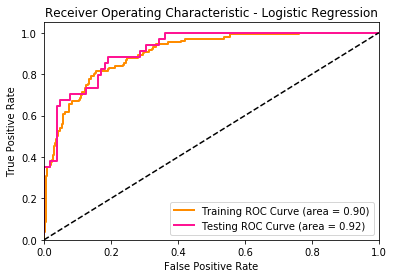

In [166]:
lr_coef = fit_and_roc(x_train, y_train, x_test, y_test)

- **Which features are important ?**

In [173]:
df_coef = pd.DataFrame(list(zip(final_features, lr_coef.flatten())), columns={'features', 'coefficient'}) \
            .sort_values(by=['coefficient'], ascending=False)
    
df_coef

,features,coefficient
1,mean_last_30_days_play_time,0.331291
9,mean_last_1_days_play_time,0.190194
11,freq_last_14_days_search,0.125831
5,mean_last_7_days_play_time,0.118787
21,device_ip,0.080558
17,freq_last_7_days_download,0.058255
18,freq_last_3_days_download,0.055248
6,freq_last_3_days_play,0.016237
19,freq_last_1_days_download,0.003162
0,freq_last_30_days_play,-0.000501


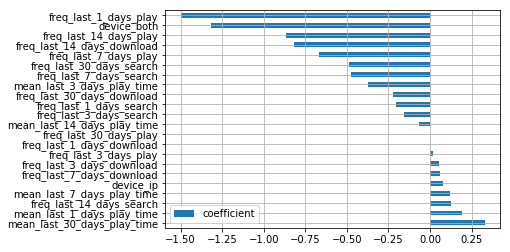

In [188]:
plt.figure(figsize=(90, 50))
ax = df_coef.plot.barh()

plt.grid(True)
ax.set_yticks(np.arange(df_coef.shape[0]))
ax.set_yticklabels(df_coef['features'])
plt.show()

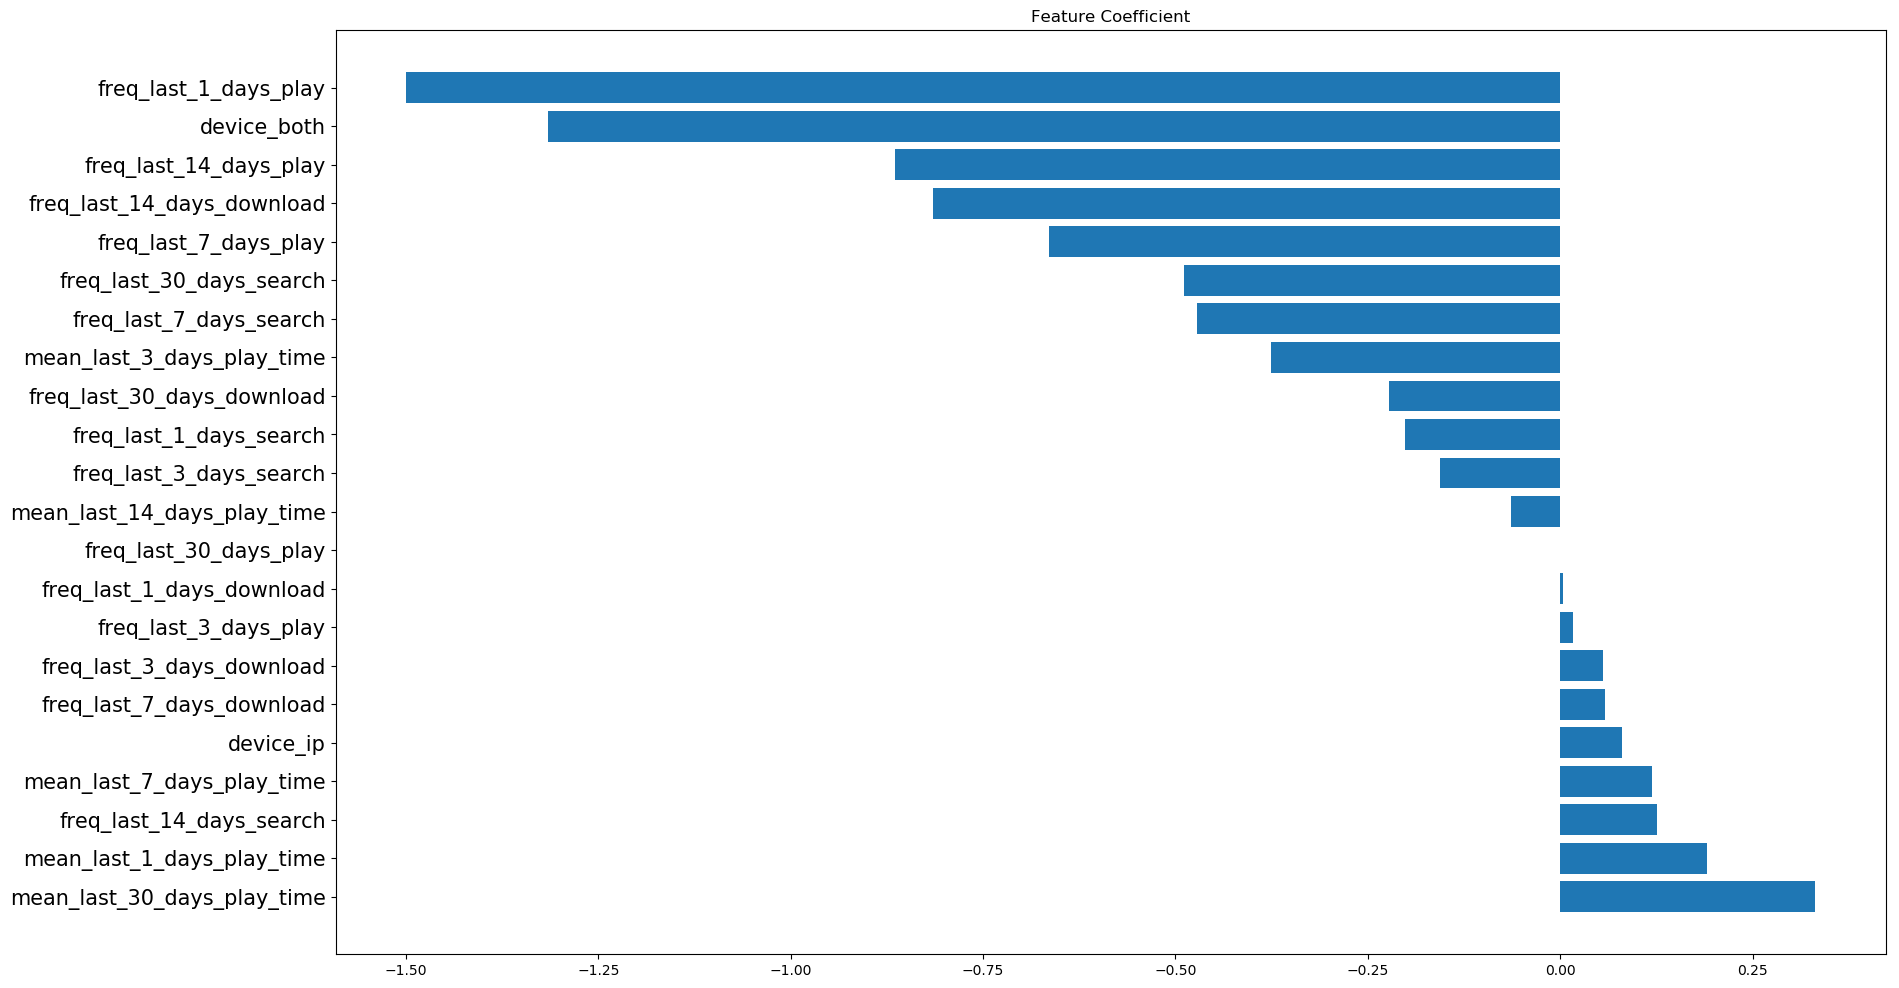

In [212]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(20,12))
ax.barh(np.arange(df_coef.shape[0]), df_coef['coefficient'], align='center')
ax.set_yticks(np.arange(df_coef.shape[0]))
ax.set_yticklabels(df_coef['features'], fontsize=15)

ax.set_title('Feature Coefficient')
plt.show()